# EJERCICIOS

In [17]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Input, Flatten, Normalization

## EJERCICIO 1

¿Cuántas neuronas hacen falta en la capa de salida para clasificar emails entre correo no deseado y correo deseado? 

¿Qué función de activación deberías usar en la capa de salida? 

Si, en cambio, quieres enfrentarte a MNIST, ¿cuántas neuronas necesitas en la capa de salida y qué función de activación deberías usar? 

¿Y si quieres que la red prediga los precios de la vivienda en California?

In [12]:
# 1 porque la salida es binaria 
# Sigmoide en la capa de salida
# Si es multiclase necesitariamo tantas neuronas como clases y softmax en la capa de salida
# Al ser regresion necesitamos una neurona 

## EJERCICIO 2

Entrena un red neuronal profunda con el conjunto de datos MNIST (puedes cargarlo con tf. keras. datasets.minst.load_data()). Intenta conseguir la mejor pruebas en el conjunto de validación  ajustando los hiperparámetros de modo manual. Prueba a buscar una buena tasa de aprendizaje y utiliza la detención temprana (mínimo hay que conseguir un 97%).

Pasos a seguir: 
+ Entrena varios modelos con distintas tasas de aprendizaje
+ Guarda cada modelo en un fichero
+ Carga cada modelo y evalúalo en el conjunto de cargas y quedate con programación con el mejor (bucle que se quede con el mejor), mostrando la tasa de aprendizaje y la exactitud del mejor modelo.

Si no obtienes más de un 97% vuelve a empezar.

In [13]:
df_mnist=tf.keras.datasets.mnist.load_data()

In [14]:
(x_train, y_train), (x_test, y_test) = df_mnist

# Normalizar los datos 
#x_train = x_train / 255.0
#x_test = x_test / 255.0


# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train, X_temp, y_train, y_temp = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Dividir el conjunto temporal en validación y prueba
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Función para crear el modelo
def create_model(learning_rate):
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Normalization(),
        Dense(300, activation="relu"),
        Dense(100, activation="relu"),
        Dense(10, activation="softmax")
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Configurar el callback de detención temprana
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Lista de tasas de aprendizaje para probar
learning_rates = [0.01, 0.001, 0.0001]

# Variables para almacenar el mejor modelo
best_model_path = None
best_accuracy = 0
best_learning_rate = None


# Probar diferentes tasas de aprendizaje
for lr in learning_rates:
    print(f"Entrenando modelo con tasa de aprendizaje: {lr}")
    model = create_model(learning_rate=lr)
    model_path = f"Resultados/model_lr_{lr}.keras"

    history = model.fit(
        X_train, y_train,
        epochs=15,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
    )

    # Guardar el modelo entrenado
    model.save(model_path)

    # Evaluar el modelo en el conjunto de prueba
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Tasa de aprendizaje: {lr}, Precisión en prueba: {test_accuracy * 100:.2f}%")

    # Guardar el mejor modelo
    if test_accuracy > best_accuracy:
        best_model_path = model_path
        best_accuracy = test_accuracy
        best_learning_rate = lr

# Cargar y mostrar los resultados del mejor modelo
best_model = tf.keras.models.load_model(best_model_path)
best_test_loss, best_test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\nMejor modelo:")
print(f"Tasa de aprendizaje: {best_learning_rate}")
print(f"Precisión en prueba: {best_test_accuracy * 100:.2f}%")

Entrenando modelo con tasa de aprendizaje: 0.01
Epoch 1/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.1482 - loss: 14.7084 - val_accuracy: 0.1040 - val_loss: 2.3017
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1059 - loss: 2.3024 - val_accuracy: 0.1137 - val_loss: 2.3017
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1123 - loss: 2.3025 - val_accuracy: 0.1137 - val_loss: 2.3025
Epoch 4/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1086 - loss: 2.3028 - val_accuracy: 0.1060 - val_loss: 2.3025
Epoch 5/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1055 - loss: 2.3032 - val_accuracy: 0.1137 - val_loss: 2.3018
Tasa de aprendizaje: 0.01, Precisión en prueba: 10.67%
Entrenando modelo con tasa de aprendizaje: 0.001
Epoch 1/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8187 - loss: 5.1625 - val_accuracy: 0.9215 - val_loss: 0.3343
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 

## EJERCICIO 3

Clasificación de Imágenes de Dígitos Escritos a Mano:

* Objetivo: Entrenar una red neuronal para clasificar imágenes de dígitos escritos a mano utilizando el conjunto de datos SVHN (Street View House Numbers).

* Tareas: 
    * Cargar el conjunto de datos, dividir los datos (train, valid y test), explorar los datos representando alguna imagen con su etiqueta y muestra los valores (únicos) de y (en el entrenamiento, en validación y en pruebas), preparar los datos (d normalizar dividiendo entre 255.0 e igual hay que hacer algo más), construir, compilar y entrenar una red neuronal. 

    * Utilizar detección temprana

    * Hacer una gráfica de como evoluciona accuracy y val_accuracy durante el entrenamiento

    * Si es necesario ajustar el modelo para lograr una mayor precisión.

    * Evalúar el modelo en el conjunto de test y hacer alguna predicción (representa alguna imagen con su etiqueta real y la predicha)

In [33]:
def load_svhn_data(url):
    path = tf.keras.utils.get_file("svhn.mat", url)
    data = loadmat(path)
    return np.transpose(data["X"], (3, 0, 1, 2)), data["y"].flatten()

# Cargar datos
train_url = "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
test_url = "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"
X_train_full, y_train_full = load_svhn_data(train_url)
X_test, y_test = load_svhn_data(test_url)
X_test2, y_test2 = load_svhn_data(test_url)

In [25]:
# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Normalizar etiquetas de clase: 10 -> 0
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0
y_val[y_val == 10] = 0

Forma de X_train: (58605, 32, 32, 3)
Forma de y_train: (58605,)
Forma de y_test: (73257,)
Forma de y_val: (14652,)
Valores únicos en y_train: [0 1 2 3 4 5 6 7 8 9]


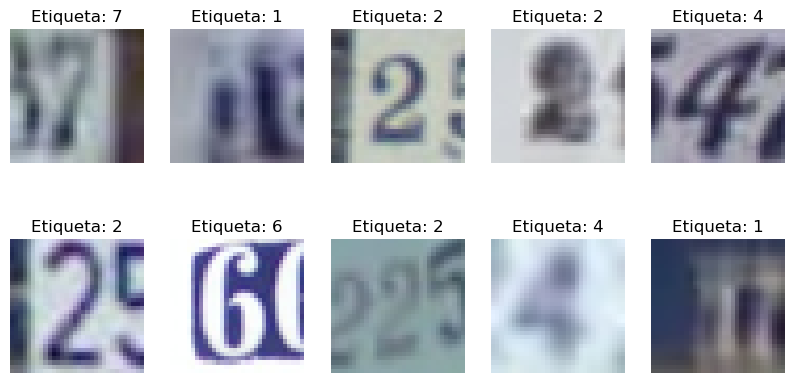

In [27]:
# Explorar los datos
print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_test:", y_test.shape)
print("Forma de y_val:", y_val.shape)
print("Valores únicos en y_train:", np.unique(y_train))

# Visualizar algunas imágenes
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Etiqueta: {y_train[i]}")
    plt.axis('off')
plt.show()

In [ ]:
# Preparar los datos
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0


# Construir el modelo
model = Sequential([
        Input(shape=(32, 32, 3)),
        Flatten(),
        Dense(150, activation="relu"),
        Dense(300, activation="relu"),
        Dense(128, activation="relu"),
        Dense(10, activation="softmax")
    ])
# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Entrenar el modelo
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
        X_train, y_train,
        epochs=15,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
    )

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Pérdida en prueba: {loss}, Precisión en prueba: {accuracy}")

Epoch 1/15


2025-01-09 17:07:05.540760: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 720138240 exceeds 10% of free system memory.


1832/1832 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.1867 - loss: 2.2359 - val_accuracy: 0.2391 - val_loss: 2.0710
Epoch 2/15
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.2612 - loss: 2.0198 - val_accuracy: 0.3361 - val_loss: 1.8245
Epoch 3/15
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.3489 - loss: 1.7860 - val_accuracy: 0.3911 - val_loss: 1.6867
Epoch 4/15
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.4197 - loss: 1.6430 - val_accuracy: 0.4789 - val_loss: 1.4987
Epoch 5/15
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4964 - loss: 1.4661 - val_accuracy: 0.5471 - val_loss: 1.3597
Epoch 6/15
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5522 - loss: 1.3437 - val_accuracy: 0.5784 - val_loss: 1.2824
Epoch 7/15
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5881 - loss: 1.2527 - val_accuracy: 0.6244 - val_loss: 1.1613
Epoch 8/15
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.6199 - loss: 1.1755 - val

2025-01-09 17:10:07.639034: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 900182016 exceeds 10% of free system memory.


2290/2290 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7178 - loss: 0.8998
Pérdida en prueba: 0.9042212963104248, Precisión en prueba: 0.7144163846969604


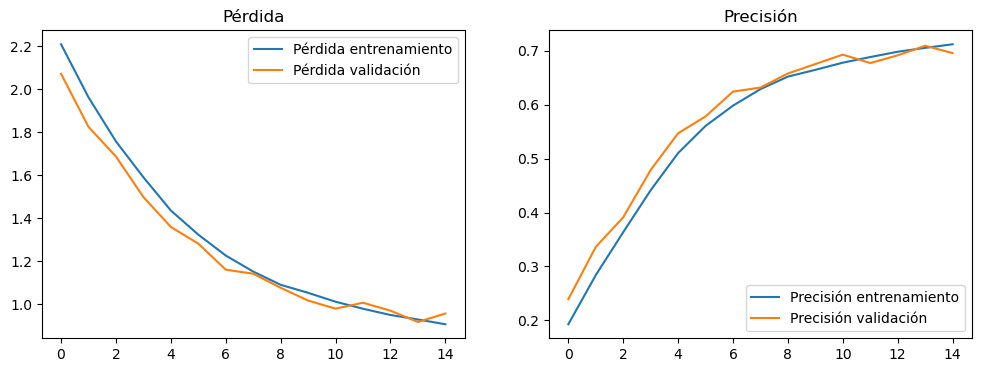

In [30]:
# Graficar el historial de entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.legend()
plt.title('Pérdida')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.legend()
plt.title('Precisión')
plt.show()

2290/2290 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


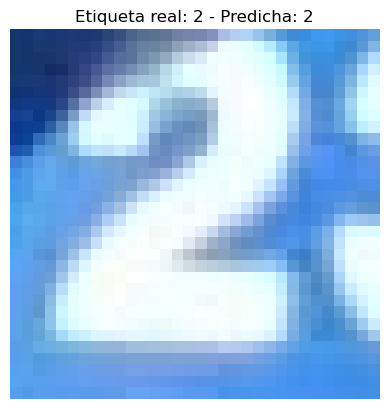

In [37]:
# Realizar una predicción y representar una imagen con etiqueta real y predicha
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Visualizar una imagen con su etiqueta real y predicha
index = 2  # Cambiar el índice para ver diferentes imágenes
plt.imshow(X_test2[index])
plt.title(f"Etiqueta real: {y_test[index]} - Predicha: {predicted_labels[index]}")
plt.axis('off')
plt.show()


## EJERCICIO 4

Predicción del consumo de energía:

* Objetivo: Construir una red neuronal para predecir el consumo de energía de edificios a partir de características como la temperatura, humedad, y tiempo del conjunto de datos Energy Efficiency de UCI Machine Learning Repository

* Tareas: 
    * Cargar el conjunto de datos, dividir los datos (train, valid y test), explorar los datos, preparar los datos (normalizar con una capa de normalización), construir un modelo de regresión, compilar y entrenar una red neuronal. 
    
    * Usa X1-X8 para la X e Y1-Y2 para la y

    * Ajusta el modelo hasta encontrar un error absoluto medio aceptable

    * Haz una gráfica de como evoluciona el error absoluto medio y error absoluto medio del conjunto de validación durante el entrenamiento

    * Evalúa el modelo en el conjunto de test y haz alguna predicción (muestra el valor predicho y el real)

In [38]:
# Descargar el conjunto de datos de eficiencia energética de UCI
url = ("https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx")
data = pd.read_excel(url)